# Image Segmentation

The algorithm consists of four steps:

### (i) re-segment the image,

### (ii) sample noise model parameters,

### (iii) sample MRF model parameters,

### (iv) sample the number of classes.

We will implement each of those sections below.

If you need to access the paper, go here:
https://static.aminer.org/pdf/PDF/000/180/822/unsupervised_image_segmentation_using_markov_random_field_models.pdf

In [144]:
import numpy as np
import imageio
from imageio import imread
import matplotlib.pyplot as plt
from scipy.stats import beta
import time

In [ ]:
Y = imread('squares.jpg') / 255
Y = np.mean(Y, axis = 2)
plt.imshow(Y, cmap = 'gray')
plt.show()

X = Y // (128/255)
plt.imshow(X, cmap = 'gray')
plt.show()

def acceptance_ratio(img_c, old_params, new_params, num_classes):
    mu_old, sig_old, T_old = old_params
    mu_new, sig_new, T_new = new_params

    ratios = []
    for s in img_c:
        new_likelihood = 1/(sig_new**2*T_new) * np.exp(-1/(2*T_new) * ((s - mu_new)/sig_new)**2)
        old_likelihood = 1/(sig_old**2*T_old) * np.exp(-1/(2*T_old) * ((s - mu_old)/sig_old)**2)
        ratios.append(new_likelihood/old_likelihood)
    print(ratios)
    acc_ratio = np.prod(np.array(ratios))
    return acc_ratio

img_c = Y.reshape(-1)[np.where(X.reshape(-1) == 0)]
img_c = np.random.uniform(0, 1, 10)
acceptance_ratio(img_c, (.3, .015, 1600), (.3, .01, 1600), 1)

## Run the entire algorithm on an image.

In [22]:
def init_labels(img):
    if len(img.shape) == 3:
        img = np.mean(img,axis=2)
        
    return img//64

def segment(img, numiter=100, alpha=(1.1, 1.5)):
    """Runs the entire segmentation algorithm.
    
    Inputs:
    
      img (ndarray) : a grayscale image to be segmented.
      
      numiter (int) : the number of iterations to compute.
      
      alpha (tuple (int)) : two constants used to calculate 
              geometric annealing temperature.
              
    Outputs:
      
      segmentation (ndarray) : an array of the same shape as 
            img where each entry is an integer indicating the
            class to which that pixel should belong.
    """
    segmentation = img//64
    img = img/np.max(img)
    noise_params = {'mu': [0,0,0,0], 'sig': [1,1,1,1]}
    mrf_params = {'beta0': [1,1,1,1], 'beta1': [1.5,1.5,1.5,1.5]}
    num_classes = 4
    params = (noise_params, mrf_params, num_classes)
    
    # Segment the image.
    for t in range(numiter):
        #print('Beginning iteration')
        # Obtain the temperature.
        T_t = (1 + alpha[0])**(alpha[1]*(1 - t/numiter))
        if t==0:
            T_t_old = T_t+1
        
        #print('Segmenting...')
        # Re-segment.
        segmentation = re_segment(img, segmentation, T_t, alpha, params)

        #print('Sampling noise...')
        # Sample noise parameters.
        noise_params = sample_noise(img, noise_params['mu'], noise_params['sig'], 
                                    segmentation, T_t, num_classes, T_t_old
                                   ) # returns a dict
    
        #print('Sampling MRF')
        # Sample MRF parameters.
        MRF_params = sample_MRF(img, mrf_params['beta0'], X, T_t, num_classes, T_t_old) # returns a dict
        #print('Took {}s\n'.format(np.round(time.time()-start),2))

        #print('Sampling number of classes')
        # Sample # of classes.
        #num_classes = sample_num_classes() # returns an int
        
        # The parameters consist of noise model params, 
        #  MRF model params, and the number of classes.
        params = (noise_params, MRF_params, num_classes)
        T_t_old = T_t
        
        plt.imshow(segmentation,cmap='gray')
        plt.title('Iteration {}'.format(t))
        plt.show()
    
    return segmentation
    

In [23]:
def V(X, c):
    mask = -((X == c) - 1/2) * 2
    new = np.zeros((X.shape[0]+2, X.shape[1]+2))
    new[0,1:-1] = mask[1,:]
    new[-1,1:-1] = mask[-2,:]
    new[1:-1,0] = mask[:,1]
    new[1:-1,-1] = mask[:,-2]
    new[1:-1, 1:-1] = mask
    v = new[:-2,1:-1] + new[1:-1, :-2] + new[2:,1:-1] + new[1:-1,2:]
    
    return v/4


def re_segment(img, X, T_t, alpha, params):
    """
    Returns the segmentation array by computing the probability
    of each pixel being in each class and returning the argmax
    """
    noise_params, MRF_params, num_classes = params
    
    probs = np.zeros((num_classes, img.shape[0], img.shape[1]))
    
    for c in range(num_classes):
        # Get the parameters for this class.
        mu = noise_params['mu'][c]
        sig = noise_params['sig'][c]
        beta0 = MRF_params['beta0'][c]
        beta1 = MRF_params['beta1'][c]
        
        # Compute the probabilities for this class
        probs[c] = 1/np.sqrt(2*np.pi*T_t*sig**2)*np.exp(
                      -1/T_t*(0.5*((img - mu)/sig)**2 
                      + (beta0 + beta1*V(X, c)))
                   )
    
    return np.argmax(probs, axis=0)

# Noise Sampling

In [ ]:
def accept(ratio, old_sample, new_sample): 
    if ratio > 1:
        # always accept
        output = new_sample
    else:
        # accept w/ probability ratio
        draw = np.random.random()
        if draw < ratio:
            # accept
            output = new_sample
        else:
            # reject
            output = old_sample
            
    return output

def noise_acceptance_ratio(img_c, old_params, new_params, num_classes):
    mu_old, sig_old, T_old = old_params
    mu_new, sig_new, T_new = new_params

    ratios = []
    for s in img_c:
        new_likelihood = 1/(sig_new**2*T_new) * np.exp(-1/(2*T_new) * ((s - mu_new)/sig_new)**2)
        old_likelihood = 1/(sig_old**2*T_old) * np.exp(-1/(2*T_old) * ((s - mu_old)/sig_old)**2)
        ratios.append(new_likelihood/old_likelihood)

    acc_ratio = np.prod(np.array(ratios))
    return acc_ratio

def noise_likelihood(img_c, mu, sig, T_t, num_classes):
    return 1/(sig*(2*np.pi*sig**2*T_t)**len(img_c))*np.exp(-1/(2*T_t)*np.sum([((y-mu)/sig)**2 for y in img_c ]))

def sample_noise(img, mu_0, sig_0, X, T_t, num_classes, T_t_old):
    """Samples the noise model parameters.
    The output is a dictionary with these keys:
    {
     'mu': an array with the mean for each class
     'sig': an array with the st. dev. for each class
    }"""
    mus = []
    sigs = []
    variance = 1
    
    for c in range(num_classes):
        # Get pixels in class
        img_c = np.ravel(img[np.where(X==c)])
        
        # Sample noise parameters
        mu_sample = np.random.normal(0,1)
        sig_sample = np.random.normal(0,1)
        
        # Calculate likelihood ratio
        ratio = noise_acceptance_ratio(img_c, (mu_0[c],sig_0[c],T_t_old), (mu_sample,sig_sample,T_t), num_classes)
        
        # Accept or reject new parameters
        mu,sig = accept(ratio,(mu_0[c], sig_0[c]), (mu_sample,sig_sample))
        
        # Save parameters
        mus.append(mu)
        sigs.append(sig)
    
    return {'mu':mus, 'sig':sigs}

# MRF Sampling

In [24]:
def accept(ratio, old_sample, new_sample): 
    if ratio > 1:
        # always accept
        output = new_sample
    else:
        # accept w/ probability ratio
        draw = np.random.random()
        if draw < ratio:
            # accept
            output = new_sample
        else:
            # reject
            output = old_sample
            
    return output

def mrf_acceptance_ratio(idx, v_vals, old_params, new_params, num_classes):
    beta_old, T_t_old = old_params
    beta_new, T_t = new_params
    beta_1 = 1.5

    ratios = []
                                
    for s in idx:
        new_likelihood_denom = np.sum([np.exp(-1/T_t * (beta_new + beta_1 * v_vals[s])) for i in range(num_classes)])
        old_likelihood_denom = np.sum([np.exp(-1/T_t_old * (beta_old + beta_1 * v_vals[s])) for i in range(num_classes)])
        
        new_likelihood = np.exp(-1/T_t*(beta_old + beta_1 * v_vals[s])) / new_likelihood_denom
        old_likelihood = np.exp(-1/T_t_old*(beta_old + beta_1 * v_vals[s])) / old_likelihood_denom
        
        ratios.append(new_likelihood/old_likelihood)

    acc_ratio = np.prod(np.array(ratios))
    return acc_ratio

def sample_MRF(img, beta_0, X, T_t, num_classes, T_t_old):
    """Samples the noise model parameters.
    The output is a dictionary with these keys:
    {
     'mu': an array with the mean for each class
     'sig': an array with the st. dev. for each class
    }"""
    betas = []
    beta_1 = 1.5
    variance = 1
    
    for c in range(num_classes):
        # Get pixels in class
        v_vals = V(X,c).reshape(-1)
        c_idx = np.where(X==c)[0]
        
        # Sample noise parameters
        beta_sample = np.random.normal(0,variance)
        
        # Calculate likelihood ratio
        ratio = mrf_acceptance_ratio(c_idx, v_vals, (beta_0[c], T_t_old), (beta_sample,T_t), num_classes)
        
        # Accept or reject new parameters
        beta = accept(ratio,beta_0[c], beta_sample)
        
        # Save parameters
        betas.append(beta)
    
    return {'beta0':betas,'beta1':np.array([1.5,1.5,1.5,1.5])}

# Sample the number of classes

In [143]:
def split_class_acc_ratio(u1, u2, u3, T_t, sig):
    """Get the acceptance ratio for splitting the current class in two.
    This is an implementation of equation (16).
    """
    posterior_density_ratio = posterior_eq_5(..) / posterior_eq_5(..)
    beta_probs = (beta.pdf(u1,1,1)*beta.pdf(u2,1,1)*beta.pdf(u3,1,1))
    p_segmentation = ??
    jac_det = jacobian_determinant(T_t, sig, u1, u2, u3)
    return posterior_density_ratio * jac_det / p_segmentation / beta_probs

def jacobian_determinant(T_t, sig, u1, u2, u3): 
    return T_t*sig**2/(u1**2*(1-u1**2)*np.sqrt(u3*(1-u3)))
    
def posterior_eq_5():
    """Implements equation 5, approximating P(X=x, \psi, k | Y = y)"""
    all_V = np.array([V(X,c) for c in range(num_classes)])
    V_C = all_V[segmentation,0,0]
    #V_C = np.zeros(all_V[0].shape)
    #for i in range(V_C.shape[0]):
    #    for j in range(V_C.shape[1]):
    #        V_C[i,j] = all_V[segmentation[i,j], i, j]
    #V_c = V(segmentation, c)
    
    first_line = ( 1/(np.sqrt(2*np.pi*sig**2))
        * np.exp(-0.5*np.sum(((img - mu)/sig)**2)) )
    second_line = (np.exp(-np.sum(beta0 + beta1*V_C))
                  / )
    
    # On the third line, we note that the priors for mu_c, beta0, 
    # beta1, and k are uniform, so we may omit them.
    third_line = np.prod([sig_prior(sig[c]) for c in range(num_classes)])
    return first_line*second_line*third_line
    
def sample_num_classes(num_classes):
    """Return an integer with the number of classes.
    
    The algorithm consists of two parts:
    
    (i) For each class, c:
        Determine if c should be split into two classes.
        
    (ii) For each pair of classes that should not be split into two:
        Determine if those two classes should be combined into one.
        
    Finish by splitting and merging these classes.
    """

    for c in range(num_classes):
        # Compute u1, u2, u3 for this class.
        u1, u2, u3 = beta.rvs(1, 1, size=3)
        
        # Decide if c should be split in two.
        acc_ratio = np.min(split_class_acc_ratio(u1, u2, u3, ...), 1)
        
    

def split_class():
    """Split a class into two separate classes, updating the
    necessary parameters as needed.
    """
    # Step 1 - draw random variables u_1, u_2, u_3 \in (0,1]
    #  from beta distributions.
    
    # Step 2 - 
    pass
    
def combine_classes():
    """Combine two classes into a single class, updating the
    necessary parameters.
    """
    pass

def V(X, c):
    mask = -((X == c) - 1/2) * 2
    new = np.zeros((X.shape[0]+2, X.shape[1]+2))
    new[0,1:-1] = mask[1,:]
    new[-1,1:-1] = mask[-2,:]
    new[1:-1,0] = mask[:,1]
    new[1:-1,-1] = mask[:,-2]
    new[1:-1, 1:-1] = mask
    v = new[:-2,1:-1] + new[1:-1, :-2] + new[2:,1:-1] + new[1:-1,2:]
    return v/4

SyntaxError: invalid syntax (<ipython-input-143-a341a24b0b73>, line 5)

In [141]:
arr = np.array([[0, 1, 2], [2, 0, 0], [1, 0, 1]])
arr2 = np.array([[[0.5,0.5,0.5], [0.5,0.5,0.5], [0.5,0.5,0.5]], [[1,1,1],[1,1,1],[1,1,1]], [[2,2,2],[2,2,2],[2,2,2]]])

In [142]:
arr2[arr,0,0]

array([[0.5, 1. , 2. ],
       [2. , 0.5, 0.5],
       [1. , 0.5, 1. ]])

In [15]:
np.random.normal(0, 1)

0.21597697896444856

In [16]:
a = (np.random.randn(16).reshape((4,4))*10).astype(int)
b = (np.random.randn(16).reshape((4,4))*10).astype(int)

In [17]:
a[b<0]

array([ 8,  4,  9,  4, 20, 13, -9, -9,  0, -2,  0])

In [65]:
numiter = 100
alpha = (1.1, 10.0)
T_t = lambda t: (1 + alpha[0])**(alpha[1]*(1 - t/numiter))

In [66]:
T_t(0) / T_t(1)

1.0770154403043628

In [108]:
def acceptance_ratio(img_c, old_params, new_params):
    mu_old, sig_old, T_old = old_params
    mu_new, sig_new, T_new = new_params
    
    ratios = ((sig_old/sig_new)**3
        * (T_old/T_new)
        * np.exp(
            1/(2*T_old)*((img_c - mu_old)/sig_old)**2
            - 1/(2*T_new)*((img_c - mu_new)/sig_new)**2
        )
    )

    acc_ratio = np.prod(ratios)
    return ratios, acc_ratio

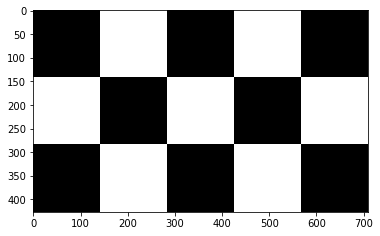

In [109]:
img = imageio.imread('imgs/checkers.gif')
plt.imshow(img, cmap='gray')

# Rescale the image
img = img / np.max(img)

In [110]:
ratios, acc_ratio = acceptance_ratio(np.ravel(img[200:235]), (0.5, 0.3, T_t(0)), (0.5, 0.05, T_t(1)))
acc_ratio

inf

In [111]:
ratios

Array([225.43231291, 225.43231291, 225.43231291, ..., 225.43231291,
       225.43231291, 225.43231291])